In [2]:
import networkx as nx
import pandas as pd
import torch
import torch_geometric
from torch_geometric.utils import from_networkx
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2  

In [3]:
NYU_PATH = "C:/Users/deshu/.cache/kagglehub/datasets/soumikrakshit/nyu-depth-v2/versions/1/nyu_data/data"
nyu_train_csv = os.path.join(NYU_PATH, "nyu2_train.csv")
nyu_test_csv = os.path.join(NYU_PATH, "nyu2_test.csv")

if os.path.exists(nyu_train_csv):
    nyu_train_df = pd.read_csv(nyu_train_csv)
    print("NYU Train CSV:", nyu_train_df.shape)
    display(nyu_train_df.head())
else:
    print("NYU Train CSV not found!")

NYU Train CSV: (50687, 2)


,data/nyu2_train/living_room_0038_out/37.jpg,data/nyu2_train/living_room_0038_out/37.png
0,data/nyu2_train/living_room_0038_out/115.jpg,data/nyu2_train/living_room_0038_out/115.png
1,data/nyu2_train/living_room_0038_out/6.jpg,data/nyu2_train/living_room_0038_out/6.png
2,data/nyu2_train/living_room_0038_out/49.jpg,data/nyu2_train/living_room_0038_out/49.png
3,data/nyu2_train/living_room_0038_out/152.jpg,data/nyu2_train/living_room_0038_out/152.png
4,data/nyu2_train/living_room_0038_out/142.jpg,data/nyu2_train/living_room_0038_out/142.png


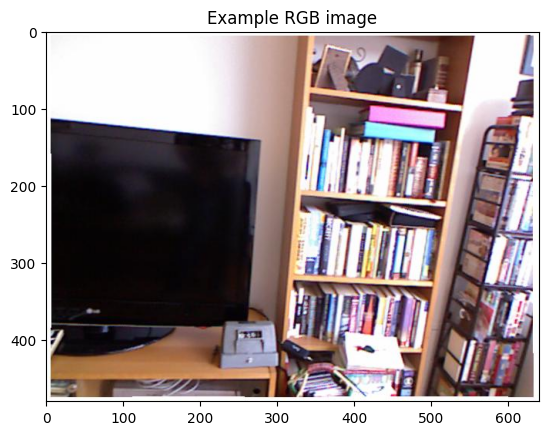

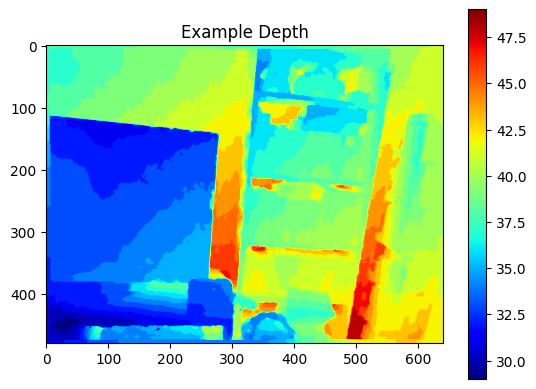

In [4]:
sample_image_path = "C:/Users/deshu/.cache/kagglehub/datasets/soumikrakshit/nyu-depth-v2/versions/1/nyu_data/data/nyu2_train/living_room_0020_out/208.jpg"
sample_depth_path = "C:/Users/deshu/.cache/kagglehub/datasets/soumikrakshit/nyu-depth-v2/versions/1/nyu_data/data/nyu2_train/living_room_0020_out/208.png"

if os.path.exists(sample_image_path):
    img = cv2.imread(sample_image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  #  BGR -> RGB for plt
    plt.imshow(img)
    plt.title("Example RGB image")
    plt.show()
else:
    print("Sample RGB image not found at:", sample_image_path)

if os.path.exists(sample_depth_path):
    depth = cv2.imread(sample_depth_path, cv2.IMREAD_UNCHANGED)
    plt.imshow(depth, cmap='jet')
    plt.title("Example Depth")
    plt.colorbar()
    plt.show()
else:
    print("Sample Depth image not found at:", sample_depth_path)

In [5]:
from torch.utils.data import DataLoader, Dataset
CSV_PATH_TRAIN = "C:/Users/deshu/.cache/kagglehub/datasets/soumikrakshit/nyu-depth-v2/versions/1/nyu_data/data/nyu2_train.csv"
CSV_PATH_TEST = "C:/Users/deshu/.cache/kagglehub/datasets/soumikrakshit/nyu-depth-v2/versions/1/nyu_data/data/nyu2_test.csv"
ROOT_DIR = "C:/Users/deshu/.cache/kagglehub/datasets/soumikrakshit/nyu-depth-v2/versions/1/nyu_data/"

nyu_train_df = pd.read_csv(CSV_PATH_TRAIN,   
                           sep=',',
                           header=None, 
                           names=["rgb", "depth"])

nyu_test_df = pd.read_csv(CSV_PATH_TEST, 
                          sep=',', 
                          header=None,
                          names=["rgb", "depth"])

In [6]:
class DepthDataset(Dataset):
    def __init__(self, dataframe, root_dir, img_height=240, img_width=320, transform=None):
        """
        :param dataframe: pd.DataFrame [rgb, depth]
        :param root_dir: folder dataframe
        :param img_height, img_width: resize to
        :param transform: augmentation
        """
        self.df = dataframe.reset_index(drop=True)
        self.root_dir = root_dir
        self.img_height = img_height
        self.img_width = img_width
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        rgb_path = os.path.join(self.root_dir, row["rgb"])   
        #print(rgb_path, os.path.exists(rgb_path))
        depth_path = os.path.join(self.root_dir, row["depth"])
        #print(depth_path, os.path.exists(depth_path))
        

        # (BGR -> RGB)
        rgb_img = cv2.imread(rgb_path)
        if rgb_img is None:
            print("Warning: Failed to load image:", rgb_path)
        rgb_img = cv2.cvtColor(rgb_img, cv2.COLOR_BGR2RGB)
        rgb_img = cv2.resize(rgb_img, (self.img_width, self.img_height))

        # Depth 
        depth_img = cv2.imread(depth_path, cv2.IMREAD_UNCHANGED)
        depth_img = cv2.resize(depth_img, (self.img_width, self.img_height))

        # to float32
        rgb_img = rgb_img.astype(np.float32) / 255.0
        depth_img = depth_img.astype(np.float32)

        # to tensor PyTorch: (C,H,W)
        rgb_tensor = torch.from_numpy(np.transpose(rgb_img, (2,0,1)))   # (3, H, W)
        depth_tensor = torch.from_numpy(depth_img).unsqueeze(0)         # (1, H, W)

        return rgb_tensor, depth_tensor

In [7]:
IMG_HEIGHT = 480
IMG_WIDTH = 640
BATCH_SIZE = 4

train_dataset = DepthDataset(nyu_train_df, ROOT_DIR, IMG_HEIGHT, IMG_WIDTH)
test_dataset = DepthDataset(nyu_test_df, ROOT_DIR, IMG_HEIGHT, IMG_WIDTH)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("Train samples:", len(train_dataset))
print("Test samples:", len(test_dataset))

Train samples: 50688
Test samples: 654


In [8]:
save_path="fly_prior.pt"
fly_prior_init = torch.load(save_path)
print(fly_prior_init.shape)

torch.Size([600, 64])


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import networkx as nx
from torch_geometric.nn import GCNConv
from torch_geometric.utils import from_networkx
from torchvision.models import resnet18, ResNet18_Weights

class ResNetMultiScale(nn.Module):
    """
    Returns multi-scale feature maps f1, f2, f3, f4 from ResNet-18.
    f1 ~ 1/4 resolution, f2 ~ 1/8, f3 ~ 1/16, f4 ~ 1/32
    """
    def __init__(self, pretrained=True):
        super().__init__()
        base_model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1 if pretrained else None)
        
        self.conv1 = base_model.conv1
        self.bn1 = base_model.bn1
        self.relu = base_model.relu
        self.maxpool = base_model.maxpool
        
        self.layer1 = base_model.layer1  # f1
        self.layer2 = base_model.layer2  # f2
        self.layer3 = base_model.layer3  # f3
        self.layer4 = base_model.layer4  # f4

    def forward(self, x):
        # x: [B, 3, H, W]
        x = self.conv1(x)   # 1/2 resolution
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x) # 1/4 resolution

        f1 = self.layer1(x) # 1/4 resolution
        f2 = self.layer2(f1) # 1/8
        f3 = self.layer3(f2) # 1/16
        f4 = self.layer4(f3) # 1/32
        return f1, f2, f3, f4

def build_grid_edge_index(H, W, connectivity=4):
    nodes = H * W
    indices = np.arange(nodes).reshape(H, W)
    edge_list = []
    if connectivity == 4:
        offsets = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    elif connectivity == 8:
        offsets = [(-1, 0), (1, 0), (0, -1), (0, 1),
                   (-1, -1), (-1, 1), (1, -1), (1, 1)]
    else:
        raise ValueError("connectivity must be 4 or 8")
    for i in range(H):
        for j in range(W):
            current = indices[i, j]
            for di, dj in offsets:
                ni, nj = i + di, j + dj
                if 0 <= ni < H and 0 <= nj < W:
                    neighbor = indices[ni, nj]
                    edge_list.append([current, neighbor])
    edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()
    return edge_index

class GNNFly(nn.Module):
    """
    Applies GCNConv layers + Fly Prior to the final ResNet feature map (f4).
    """
    def __init__(self, in_channels=512, gnn_hidden_dim=64, fly_embed_dim=64,
                 num_nodes=600, fly_pt_path="fly_prior.pt", num_gnn_layers=2, connectivity=4):
        super().__init__()
        self.in_channels = in_channels
        self.gnn_hidden_dim = gnn_hidden_dim
        self.fly_embed_dim = fly_embed_dim
        self.num_nodes = num_nodes
        self.connectivity = connectivity
        
        # GNN layers
        self.gnn_layers = nn.ModuleList()
        cur_in = in_channels
        for _ in range(num_gnn_layers):
            self.gnn_layers.append(GCNConv(cur_in, gnn_hidden_dim))
            cur_in = gnn_hidden_dim
        
        # Create an Embedding to hold the fly prior
        self.fly_prior = nn.Embedding(self.num_nodes, self.fly_embed_dim)
        
        # Load the precomputed Tensor from disk (shape [num_nodes, fly_embed_dim])
        fly_prior_init = torch.load(fly_pt_path)  
        
        # Copy the loaded Tensor into self.fly_prior's weights
        with torch.no_grad():
            self.fly_prior.weight.copy_(fly_prior_init)
        
        # Fusion layer
        self.fusion = nn.Linear(gnn_hidden_dim + fly_embed_dim, gnn_hidden_dim)

    def forward(self, feat_map):
        """
        feat_map: [B, in_channels, H4, W4]
        returns:  [B, gnn_hidden_dim, H4, W4]
        """
        B, C, H4, W4 = feat_map.shape
        num_nodes_actual = H4 * W4
        
        # Build edge_index
        edge_index = build_grid_edge_index(H4, W4, connectivity=self.connectivity).to(feat_map.device)
        
        outputs = []
        for b in range(B):
            node_feats = feat_map[b].view(C, -1).t()  # [num_nodes_actual, C]
            
            # GNN
            for conv in self.gnn_layers:
                node_feats = conv(node_feats, edge_index)
                node_feats = F.relu(node_feats)
            
            # Fly Prior
            if num_nodes_actual != self.num_nodes:
                fly_embed = self.fly_prior.weight[:num_nodes_actual]
            else:
                fly_embed = self.fly_prior.weight
            
            # Fusion
            fused = torch.cat([node_feats, fly_embed], dim=1)  # [num_nodes_actual, gnn_hidden_dim + fly_embed_dim]
            fused = self.fusion(fused)  # [num_nodes_actual, gnn_hidden_dim]
            
            
            fused_grid = fused.t().view(1, self.gnn_hidden_dim, H4, W4)
            outputs.append(fused_grid)
        
        return torch.cat(outputs, dim=0)  

class MultiScaleDecoder(nn.Module):
    """
    U-Net style decoder that fuses multi-scale features (f1, f2, f3, f4_gnn).
    Produces a coarse depth at full resolution.
    """
    def __init__(self):
        super().__init__()
        self.up4 = nn.ConvTranspose2d(64, 256, kernel_size=2, stride=2)       # => 1/16
        self.up3 = nn.ConvTranspose2d(256+256, 128, kernel_size=2, stride=2)  # => 1/8
        self.up2 = nn.ConvTranspose2d(128+128, 64, kernel_size=2, stride=2)   # => 1/4
        self.up1 = nn.ConvTranspose2d(64+64, 64, kernel_size=2, stride=2)     # => 1/2
        
        self.final_conv = nn.Conv2d(64, 1, kernel_size=3, padding=1)

    def forward(self, f1, f2, f3, f4_gnn):
        x = self.up4(f4_gnn)           # => ~1/16
        x = torch.cat([x, f3], dim=1)  # => [B, 64+256, 1/16, 1/16]
        
        x = self.up3(x)                # => ~1/8
        x = torch.cat([x, f2], dim=1)  # => [B, 128+128, 1/8, 1/8]
        
        x = self.up2(x)                # => ~1/4
        x = torch.cat([x, f1], dim=1)  # => [B, 64+64, 1/4, 1/4]
        
        x = self.up1(x)                # => ~1/2
        x = self.final_conv(x)         # => shape [B, 1, H/2, W/2]
        
        B, _, H2, W2 = x.shape
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
        
        return x


class DepthRefinementNet(nn.Module):
    """
    Small U-Net that refines coarse depth with the original RGB.
    Input: cat(RGB, coarse_depth) => [B, 4, H, W]
    Output: refined depth => [B, 1, H, W]
    """
    def __init__(self):
        super().__init__()
        self.enc1 = nn.Conv2d(4, 32, 3, padding=1)
        self.enc2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2)
        
        self.dec2 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.dec1 = nn.Conv2d(32, 16, 3, padding=1)
        
        self.final_conv = nn.Conv2d(16, 1, kernel_size=3, padding=1)

    def forward(self, rgb, depth_coarse):
        """
        rgb: [B, 3, H, W]
        depth_coarse: [B, 1, H, W]
        """
        x = torch.cat([rgb, depth_coarse], dim=1)  # [B, 4, H, W]
        
        x = F.relu(self.enc1(x))
        x = self.pool(F.relu(self.enc2(x)))  # [B, 64, H/2, W/2]
        
        x = self.dec2(x)                    # [B, 32, H, W]
        x = F.relu(self.dec1(x))            # [B, 16, H, W]
        
        x = self.final_conv(x)              # [B, 1, H, W]
        return x


class FlyDepthModel(nn.Module):
    """
    1) Multi-scale ResNet -> (f1, f2, f3, f4)
    2) GNN on f4 -> f4_gnn
    3) Multi-scale decoder -> coarse_depth (full resolution)
    4) Refinement net -> refined_depth
    """
    def __init__(self,
                 resnet_pretrained=True,
                 gnn_hidden_dim=64,
                 fly_embed_dim=64,
                 num_nodes=600,
                 fly_pt_path="fly_prior.pt"):
        super().__init__()
        self.backbone = ResNetMultiScale(pretrained=resnet_pretrained)
        
        self.gnn_fly = GNNFly(
            in_channels=512,
            gnn_hidden_dim=gnn_hidden_dim,
            fly_embed_dim=fly_embed_dim,
            num_nodes=num_nodes,
            fly_pt_path=fly_pt_path,
            num_gnn_layers=2,
            connectivity=4
        )
        
        self.decoder = MultiScaleDecoder()
        self.refiner = DepthRefinementNet()

    def forward(self, x):
        """
        x: [B, 3, H, W]
        Returns: refined depth => [B, 1, H, W]
        """
        f1, f2, f3, f4 = self.backbone(x)  # f4: [B,512,H/32,W/32]
        f4_gnn = self.gnn_fly(f4)  # => [B,64,H/32,W/32]
        depth_coarse = self.decoder(f1, f2, f3, f4_gnn)  # => [B,1,H,W]
        depth_refined = self.refiner(x, depth_coarse)    # => [B,1,H,W]
        return depth_refined


IMG_HEIGHT = 480
IMG_WIDTH = 640
BATCH_SIZE = 4

train_dataset = DepthDataset(nyu_train_df, ROOT_DIR, img_height=IMG_HEIGHT, img_width=IMG_WIDTH)
test_dataset = DepthDataset(nyu_test_df, ROOT_DIR, img_height=IMG_HEIGHT, img_width=IMG_WIDTH)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("Train samples:", len(train_dataset))
print("Test samples:", len(test_dataset))

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = FlyDepthModel(
#     resnet_pretrained=True,
#     gnn_hidden_dim=64,
#     fly_embed_dim=64,
#     num_nodes=600,          
#     fly_pt_path="fly_prior.pt"
# ).to(device)

# optimizer = optim.Adam(model.parameters(), lr=1e-4)
# loss_fn = nn.MSELoss()
# num_epochs = 10

# model.train()
# print("Training Start")
# for epoch in range(num_epochs):
#     epoch_loss = 0.0
#     for rgb_tensor, depth_tensor in train_loader:
#         rgb_tensor = rgb_tensor.to(device)
#         depth_tensor = depth_tensor.to(device).float()
        
#         optimizer.zero_grad()
#         pred_depth = model(rgb_tensor)  # => [B,1,H,W]
#         loss = loss_fn(pred_depth, depth_tensor)
#         loss.backward()
#         optimizer.step()
        
#         epoch_loss += loss.item() * rgb_tensor.size(0)
    
#     avg_loss = epoch_loss / len(train_dataset)
#     print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}")

# print("Training complete")

Train samples: 50688
Test samples: 654


In [10]:
checkpoint_path = "FlyDepthModel.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FlyDepthModel(
    resnet_pretrained=True,
    gnn_hidden_dim=64,
    fly_embed_dim=64,
    num_nodes=600,          
    fly_pt_path="fly_prior.pt"
).to(device)

checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded model from epoch {checkpoint['epoch']} with final loss {checkpoint['loss']:.4f}")

Loaded model from epoch 10 with final loss 35.8090


In [11]:
def test_and_visualize(model, data_loader, device):
    model.eval()  
    with torch.no_grad():
        for rgb_tensor, depth_tensor in data_loader:
            rgb_tensor = rgb_tensor.to(device)
            depth_tensor = depth_tensor.to(device).float()
            
            pred_depth = model(rgb_tensor)  # Shape: [B, 1, H, W]
            
            pred_depth = pred_depth.cpu().numpy()
            depth_tensor = depth_tensor.cpu().numpy()
            rgb_tensor = rgb_tensor.cpu().numpy()
            
            idx = 0
            rgb_img = np.transpose(rgb_tensor[idx], (1, 2, 0))  
            gt_depth = depth_tensor[idx, 0, :, :]
            pred_heatmap = pred_depth[idx, 0, :, :]

            plt.figure(figsize=(18, 6))
            
            plt.subplot(1, 3, 1)
            plt.imshow(rgb_img)
            plt.title("RGB Image")
            plt.axis("off")

            plt.subplot(1, 3, 2)
            plt.imshow(gt_depth, cmap='viridis')
            plt.title("Ground Truth Depth")
            plt.axis("off")

            plt.subplot(1, 3, 3)
            plt.imshow(pred_heatmap, cmap='viridis')
            plt.title("Predicted Depth Heat Map")
            plt.axis("off")

            plt.show()
            break

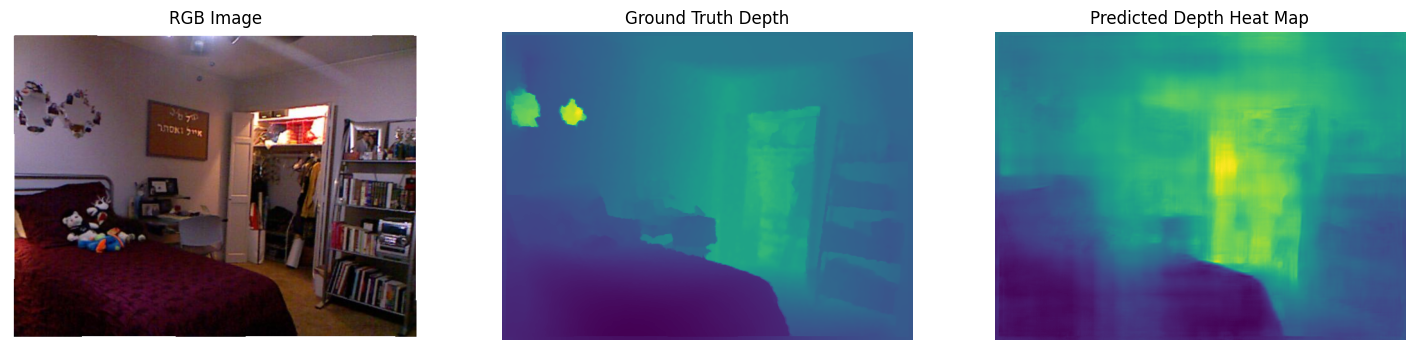

In [12]:
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle = True)
test_and_visualize(model, test_loader, device)

In [13]:
import os
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
import scipy.ndimage
from torchvision import transforms

def guided_filter(I, p, radius=64, eps=1e-3):
    """
    Perform guided filtering to refine the depth map.
    :param I: Guidance image (grayscale)
    :param p: Input image to be filtered (depth map)
    :param radius: Window radius
    :param eps: Regularization term
    :return: Filtered image
    """
    mean_I = scipy.ndimage.uniform_filter(I, radius)
    mean_p = scipy.ndimage.uniform_filter(p, radius)
    corr_I = scipy.ndimage.uniform_filter(I * I, radius)
    corr_Ip = scipy.ndimage.uniform_filter(I * p, radius)

    var_I = corr_I - mean_I * mean_I
    cov_Ip = corr_Ip - mean_I * mean_p

    a = cov_Ip / (var_I + eps)
    b = mean_p - a * mean_I

    mean_a = scipy.ndimage.uniform_filter(a, radius)
    mean_b = scipy.ndimage.uniform_filter(b, radius)

    q = mean_a * I + mean_b
    return q

def apply_guided_filter(rgb_img, pred_heatmap):
    """
    Use the RGB image (converted to grayscale) as guidance to refine the depth map.
    """
    guide_gray = np.mean(rgb_img, axis=2)  # simple average to convert to grayscale
    return guided_filter(guide_gray, pred_heatmap)

def enhance_sharpness(image, alpha=1.5, beta=-0.5):
    """
    Enhance image sharpness using unsharp masking.
    :param image: Input image (grayscale)
    :param alpha: Weight for the original image.
    :param beta: Weight for the blurred image.
    :return: Sharpened image.
    """
    blurred = cv2.GaussianBlur(image, (0, 0), 3)
    sharpened = cv2.addWeighted(image, alpha, blurred, beta, 0)
    return sharpened

def load_and_preprocess_image(image_path, img_height=480, img_width=640):
    """
    Load an image from disk, resize, normalize, and convert to a torch tensor.
    """
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Could not load image from: {image_path}")
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (img_width, img_height))
    img = img.astype(np.float32) / 255.0
    img_tensor = torch.from_numpy(np.transpose(img, (2, 0, 1)))  
    img_tensor = img_tensor.unsqueeze(0)  
    
    return img_tensor, img  


def test_image_path(model, device, image_path, save_dir="output", img_height=480, img_width=640):
    """
    Load an image from a given path, run the model to predict depth, and apply guided filtering
    and sharpness enhancement to refine the depth map.
    Saves and visualizes the results.
    """
    os.makedirs(os.path.join(save_dir, "rgb_images"), exist_ok=True)
    os.makedirs(os.path.join(save_dir, "predicted_depth"), exist_ok=True)
    os.makedirs(os.path.join(save_dir, "filtered_depth"), exist_ok=True)
    
    img_tensor, rgb_img = load_and_preprocess_image(image_path, img_height, img_width)
    img_tensor = img_tensor.to(device)
    
    model.eval()
    with torch.no_grad():
        pred_depth = model(img_tensor)
    
    pred_depth = torch.nn.functional.interpolate(pred_depth, size=(img_height, img_width), mode='bilinear', align_corners=True)
    
    pred_depth_np = pred_depth.squeeze().cpu().numpy()  
    
    pred_depth_norm = cv2.normalize(pred_depth_np, None, 0, 255, cv2.NORM_MINMAX)
    pred_depth_norm = np.uint8(pred_depth_norm)
    
    refined_depth = apply_guided_filter(rgb_img, pred_depth_norm)
    
    refined_depth_sharp = enhance_sharpness(refined_depth)
    
    base_filename = os.path.splitext(os.path.basename(image_path))[0]
    rgb_save_path = os.path.join(save_dir, "rgb_images", f"{base_filename}_rgb.png")
    depth_save_path = os.path.join(save_dir, "predicted_depth", f"{base_filename}_depth.png")
    filtered_save_path = os.path.join(save_dir, "filtered_depth", f"{base_filename}_filtered.png")
    
    cv2.imwrite(rgb_save_path, cv2.cvtColor((rgb_img * 255).astype(np.uint8), cv2.COLOR_RGB2BGR))
    cv2.imwrite(depth_save_path, pred_depth_norm)
    cv2.imwrite(filtered_save_path, refined_depth_sharp)
    
    print(f"Saved: {rgb_save_path}, {depth_save_path}, and {filtered_save_path}")
    
    plt.figure(figsize=(24, 6))
    
    plt.subplot(1, 4, 1)
    plt.imshow(rgb_img)
    plt.title("RGB Image")
    plt.axis("off")
    
    plt.subplot(1, 4, 2)
    plt.imshow(pred_depth_np, cmap='viridis')
    plt.title("Predicted Depth Heatmap")
    plt.axis("off")
    
    plt.subplot(1, 4, 3)
    plt.imshow(refined_depth, cmap='viridis')
    plt.title("Refined Depth (Guided Filter)")
    plt.axis("off")
    
    plt.subplot(1, 4, 4)
    plt.imshow(refined_depth_sharp, cmap='viridis')
    plt.title("Refined Depth (Sharpness Enhanced)")
    plt.axis("off")
    
    plt.show()
    

# image_paths = ["C:/Users/deshu/Desktop/FlyBrain/rgb_img_virtualKitty/rgb_img_virtualKitty/1.png",
#               "C:/Users/deshu/Desktop/FlyBrain/rgb_img_virtualKitty/rgb_img_virtualKitty/2.png",
#               "C:/Users/deshu/Desktop/FlyBrain/rgb_img_virtualKitty/rgb_img_virtualKitty/3.png",
#               "C:/Users/deshu/Desktop/FlyBrain/rgb_img_virtualKitty/rgb_img_virtualKitty/4.png",
#               "C:/Users/deshu/Desktop/FlyBrain/rgb_img_virtualKitty/rgb_img_virtualKitty/5.png",
#               "C:/Users/deshu/Desktop/FlyBrain/rgb_img_virtualKitty/rgb_img_virtualKitty/6.png",
#               "C:/Users/deshu/Desktop/FlyBrain/rgb_img_virtualKitty/rgb_img_virtualKitty/7.png",
#               "C:/Users/deshu/Desktop/FlyBrain/rgb_img_virtualKitty/rgb_img_virtualKitty/8.png",
#               "C:/Users/deshu/Desktop/FlyBrain/rgb_img_virtualKitty/rgb_img_virtualKitty/9.png",
#               "C:/Users/deshu/Desktop/FlyBrain/rgb_img_virtualKitty/rgb_img_virtualKitty/10.png",
#               "C:/Users/deshu/Desktop/FlyBrain/Testing_Images/4.jpg",
#               "C:/Users/deshu/Desktop/FlyBrain/Testing_Images/5.jpg",
#               "C:/Users/deshu/Desktop/FlyBrain/Testing_Images/6.jpg",
#               "C:/Users/deshu/Desktop/FlyBrain/Testing_Images/7.jpg",
#               "C:/Users/deshu/Desktop/FlyBrain/Testing_Images/8.jpg",
#               "C:/Users/deshu/Desktop/FlyBrain/Testing_Images/9.jpg",
#               "C:/Users/deshu/Desktop/FlyBrain/Testing_Images/10.jpg",
#               "C:/Users/deshu/Desktop/FlyBrain/Testing_Images/11.jpg",
#               "C:/Users/deshu/Desktop/FlyBrain/Testing_Images/12.jpg",]

# for image_path in image_paths:
#     test_image_path(model, device, image_path, save_dir="output")

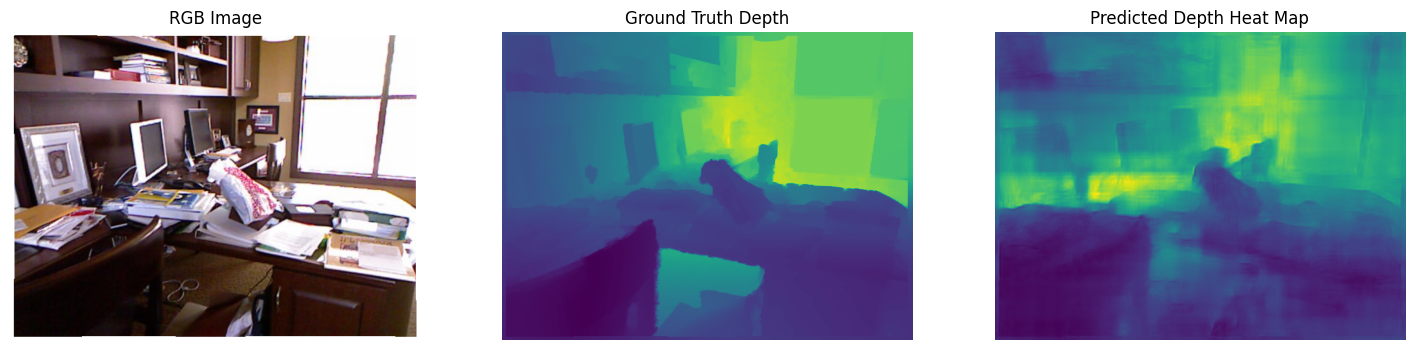

In [14]:
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_and_visualize(model, test_loader, device)

In [15]:
def compute_abs_rel_error(estimated_depth_path, benchmark_depth_path):
    """
    Compute Absolute Relative Difference between the estimated and benchmark depth maps.

    :param estimated_depth_path: Path to the estimated depth image.
    :param benchmark_depth_path: Path to the benchmark depth image.
    :return: Absolute Relative Difference
    """
    
    # Load the images as grayscale (depth maps)
    estimated_depth = cv2.imread(estimated_depth_path, cv2.IMREAD_UNCHANGED).astype(np.float32)
    benchmark_depth = cv2.imread(benchmark_depth_path, cv2.IMREAD_UNCHANGED).astype(np.float32)
    
    # Ensure no division by zero
    mask = benchmark_depth > 1e-6  # Avoid zero values in ground truth

    # Compute Absolute Relative Difference
    abs_rel = np.mean(np.abs(estimated_depth[mask] - benchmark_depth[mask]) / benchmark_depth[mask])
    return abs_rel

In [16]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage

def guided_filter(I, p, radius=64, eps=1e-3):
    """
    Perform guided filtering to refine the depth map.
    :param I: Guidance image (grayscale)
    :param p: Input image to be filtered (depth map)
    :param radius: Window radius
    :param eps: Regularization term
    :return: Filtered image
    """
    mean_I = scipy.ndimage.uniform_filter(I, radius)
    mean_p = scipy.ndimage.uniform_filter(p, radius)
    corr_I = scipy.ndimage.uniform_filter(I * I, radius)
    corr_Ip = scipy.ndimage.uniform_filter(I * p, radius)

    var_I = corr_I - mean_I * mean_I
    cov_Ip = corr_Ip - mean_I * mean_p

    a = cov_Ip / (var_I + eps)
    b = mean_p - a * mean_I

    mean_a = scipy.ndimage.uniform_filter(a, radius)
    mean_b = scipy.ndimage.uniform_filter(b, radius)

    q = mean_a * I + mean_b
    return q

def apply_guided_filter(rgb_img, pred_heatmap):
    # Convert RGB to grayscale
    guide_gray = np.mean(rgb_img, axis=2)  
    return guided_filter(guide_gray, pred_heatmap)

def enhance_sharpness(image, alpha=1.5, beta=-0.5):
    """
    Apply unsharp masking to enhance the sharpness of the image.
    :param image: Input grayscale image.
    :param alpha: Weight for the original image.
    :param beta: Weight for the blurred image.
    :return: Sharpened image.
    """
    blurred = cv2.GaussianBlur(image, (0, 0), 3)  # Gaussian Blur
    sharpened = cv2.addWeighted(image, alpha, blurred, beta, 0)
    return sharpened

def test_and_visualize(model, data_loader, device, save_dir="output"):
    model.eval()
    os.makedirs(f"{save_dir}/rgb_images", exist_ok=True)
    os.makedirs(f"{save_dir}/predicted_depth", exist_ok=True)
    os.makedirs(f"{save_dir}/filtered_depth", exist_ok=True)
    os.makedirs(f"{save_dir}/ground_truth", exist_ok=True)

    with torch.no_grad():
        for batch_idx, (rgb_tensor, depth_tensor) in enumerate(data_loader):
            rgb_tensor = rgb_tensor.to(device)
            depth_tensor = depth_tensor.to(device).float()
            
            pred_depth = model(rgb_tensor)  

            pred_depth = pred_depth.cpu().numpy()
            depth_tensor = depth_tensor.cpu().numpy()
            rgb_tensor = rgb_tensor.cpu().numpy()

            idx = 0
            rgb_img = np.transpose(rgb_tensor[idx], (1, 2, 0))  
            gt_depth = depth_tensor[idx, 0, :, :]
            pred_heatmap = pred_depth[idx, 0, :, :]
            
            pred_heatmap_norm = cv2.normalize(pred_heatmap, None, 0, 255, cv2.NORM_MINMAX)
            pred_heatmap_norm = np.uint8(pred_heatmap_norm)
            
            ground_truth = cv2.normalize(gt_depth, None, 0, 255, cv2.NORM_MINMAX)
            ground_truth = np.uint8(ground_truth)

            refined_depth = apply_guided_filter(rgb_img, pred_heatmap_norm)

            refined_depth_sharp = enhance_sharpness(refined_depth)

            rgb_save_path = os.path.join(save_dir, "rgb_images", f"rgb_{batch_idx}.png")
            depth_save_path = os.path.join(save_dir, "predicted_depth", f"depth_{batch_idx}.png")
            filtered_save_path = os.path.join(save_dir, "filtered_depth", f"filtered_depth_{batch_idx}.png")
            gt_save_path = os.path.join(save_dir, "ground_truth", f"ground_truth_{batch_idx}.png")

            cv2.imwrite(rgb_save_path, cv2.cvtColor((rgb_img * 255).astype(np.uint8), cv2.COLOR_RGB2BGR))
            cv2.imwrite(depth_save_path, pred_heatmap_norm)
            cv2.imwrite(filtered_save_path, refined_depth_sharp)
            cv2.imwrite(gt_save_path, ground_truth)

#             print(f"Saved: {rgb_save_path}, {depth_save_path}, {filtered_save_path} and {gt_save_path}")

#             plt.figure(figsize=(24, 6))

#             plt.subplot(1, 4, 1)
#             plt.imshow(rgb_img)
#             plt.title("RGB Image")
#             plt.axis("off")

#             plt.subplot(1, 4, 2)
#             plt.imshow(gt_depth, cmap='viridis')
#             plt.title("Ground Truth Depth")
#             plt.axis("off")

#             plt.subplot(1, 4, 3)
#             plt.imshow(pred_heatmap, cmap='viridis')
#             plt.title("Predicted Depth Heatmap")
#             plt.axis("off")

#             plt.subplot(1, 4, 4)
#             plt.imshow(refined_depth_sharp, cmap='viridis')
#             plt.title("Refined Depth (Guided + Sharpened)")
#             plt.axis("off")

#             plt.show()
#             break
    return rgb_save_path, depth_save_path, filtered_save_path, gt_save_path 

# avg_abs_rel = 0
# for i in range(20):
#     print(i)
#     test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
#     rgb_save_path, depth_save_path, filtered_save_path, gt_save_path = test_and_visualize(model, test_loader, device)
#     abs_rel = compute_abs_rel_error(depth_save_path, gt_save_path)
#     avg_abs_rel += abs_rel
    
# print(avg_abs_rel/100)

In [17]:
def compute_threshold_accuracy(estimated_depth_path, benchmark_depth_path, thresholds=[1.25]):
    """
    Compute threshold accuracy metrics for depth estimation.

    :param estimated_depth_path: Path to the estimated depth image.
    :param benchmark_depth_path: Path to the benchmark depth image.
    :param thresholds: List of threshold values (default: [1.25, 1.5625, 1.953125])
    :return: Dictionary with threshold accuracy scores
    """

    # Check if files exist
    if not os.path.exists(estimated_depth_path):
        raise FileNotFoundError(f"Error: File not found - {estimated_depth_path}")
    if not os.path.exists(benchmark_depth_path):
        raise FileNotFoundError(f"Error: File not found - {benchmark_depth_path}")

    # Load the images
    estimated_depth = cv2.imread(estimated_depth_path, cv2.IMREAD_UNCHANGED)
    benchmark_depth = cv2.imread(benchmark_depth_path, cv2.IMREAD_UNCHANGED)

    # Validate images
    if estimated_depth is None:
        raise ValueError(f"Error: Failed to load image - {estimated_depth_path}")
    if benchmark_depth is None:
        raise ValueError(f"Error: Failed to load image - {benchmark_depth_path}")

    # Convert to float
    estimated_depth = estimated_depth.astype(np.float32)
    benchmark_depth = benchmark_depth.astype(np.float32)

    # Ensure no division by zero
    mask = benchmark_depth > 1e-6  # Ignore invalid depth values

    # Compute delta_i values
    delta = np.maximum(estimated_depth[mask] / benchmark_depth[mask], benchmark_depth[mask] / estimated_depth[mask])

    # Compute threshold accuracies
    accuracy_scores = {}
    for t in thresholds:
        accuracy_scores[f"delta_{t}"] = np.mean(delta < t) * 100  # Convert to percentage

    return accuracy_scores

In [18]:
avg_accuracy = 0
for i in range(20):
    print(i)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
    rgb_save_path, depth_save_path, filtered_save_path, gt_save_path = test_and_visualize(model, test_loader, device)
    accuracy_score = compute_threshold_accuracy(depth_save_path, gt_save_path)
    avg_accuracy += accuracy_score
    
print(avg_abs_rel/20)

0


C:\Users\deshu\AppData\Local\Temp\ipykernel_11496\1792829416.py:35: RuntimeWarning: divide by zero encountered in divide
  delta = np.maximum(estimated_depth[mask] / benchmark_depth[mask], benchmark_depth[mask] / estimated_depth[mask])


TypeError: unsupported operand type(s) for +=: 'int' and 'dict'

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
rgb_save_path, depth_save_path, filtered_save_path, gt_save_path = test_and_visualize(model, test_loader, device)
accuracy_score = compute_threshold_accuracy(depth_save_path, gt_save_path)
print(accuracy_score['delta_1.25'])
print(type(accuracy_score['delta_1.25']))

In [21]:
a = 4.5
print(type(a))

<class 'float'>
